## Clusters Formation- Randomized Search- Evaluate your clusters
### Plot cluster fromation
### Verify cluster formation with an alternating technique

#### To vaildate the cluster formation in the data set - AK2_SIMILARITY_CLUSTERS_FEEDBACK_202207121328.csv' 

In [1]:
try:
    import pandas as pd
    import numpy as np
    import os

    # to get the embeddings
    from sentence_transformers import SentenceTransformer

    # Formation of clusters with hdbscan technique
    import hdbscan
    from sklearn.model_selection import RandomizedSearchCV

    from sklearn.metrics import make_scorer
    import logging
    
    import seaborn as sns
    print('All the libraries are found')
except:
    print("One or more libraries need to be installed")
    



All the libraries are found


In [2]:
# function to read the data
def read_data(path,file_name):
    df = pd.read_csv(path + filename,parse_dates=['CREATION_DATE'], index_col=0)
    return df
filename = 'AK2_SIMILARITY_CLUSTERS_FEEDBACK_202207121328.csv'
path = '../data/'
cluster_FB_data = read_data(path,filename)

In [3]:
# function to get the clusters from the given data
def get_clusters(data):
    _dictionary = {}
    _lists = []
    cluster_names = list(data.CLUSTER_LABEL.unique())
    for i in cluster_names:
        cluster  = list(data[data.CLUSTER_LABEL == i]['CASE_NUMBER'])
        _dictionary[i]=cluster
        _lists.append(cluster)
    
    
    return _lists, _dictionary
         
    
cluster_lists,cluster_dictionary= get_clusters(cluster_FB_data)  

In [4]:
# read the source data from where this cluster feedback data is derived
# function
file_name ='mysql_local_snapshot.pickle'
def read_pickle_file(filename):
    data=pd.read_pickle('../data/'+ filename)
    return data
df = read_pickle_file(file_name)

In [5]:
# function to get the casenumbers of clusters feedback data from the source data
def get_source_data(df,clusters):
    data = []
    for cluster in clusters:
        collect = df[df['CASE_NUMBER'].isin(cluster)]
        data.append(collect)
        
    df=pd.concat(data)                  
    
        
    return df

cluster_df = get_source_data(df,cluster_lists)
cluster_df=cluster_df[['CASE_NUMBER','_TEXT_LONG']]

In [6]:
def get_embeddings(model, text): 
    embedder = model
    sentences = text.to_list()
    embeddings = embedder.encode(sentences)
    return embeddings

model_chosen = 'all-MiniLM-L6-v2'
embeddings = get_embeddings(SentenceTransformer(model_chosen),cluster_df['_TEXT_LONG'])


In [7]:
# normalize the embeddings if you want
def normalize_embeddings(embeddings_to_normalize):
    embeddings_normalized = embeddings / np.linalg.norm(embeddings,axis=1,keepdims=True)
    return embeddings_normalized

normalized_embeddings = normalize_embeddings(embeddings)    

In [8]:
# choose clustering_algorithm
def algo(embeddings,algorithm):
    
    fit_model = algorithm.HDBSCAN(gen_min_span_tree=True).fit(embeddings)
    return fit_model


hdb = algo(normalized_embeddings,hdbscan)    

In [9]:
logging.captureWarnings(True)
def randomized_search(n_iter_search,embeddings,algo):
    SEED = 14
    hdb = algo.HDBSCAN(gen_min_span_tree=True).fit(embeddings)
    # specify parameters and distributions to sample from
    param_dist = {'min_samples': np.arange(1,7).tolist() ,
                  'min_cluster_size':[3,4,5,6,7,8,9,10],  
                  'cluster_selection_method' : ['eom','leaf'],
                  'metric' : ['euclidean','manhattan'] 
                 }

    #validity_scroer = "hdbscan__hdbscan___HDBSCAN__validity_index"
    validity_scorer = make_scorer(hdbscan.validity.validity_index,greater_is_better=True)
    
    #n_iter_search = 500
    random_search = RandomizedSearchCV(hdb,
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   scoring=validity_scorer,
                                   random_state=SEED)

    random_search.fit(embeddings)
    best_params = random_search.best_params_
    labels =  random_search.best_estimator_.labels_
    DBCV_score = random_search.best_estimator_.relative_validity_
    
    print(f"Best Parameters {random_search.best_params_}")
    print(f"DBCV score :{random_search.best_estimator_.relative_validity_}")
    
    return best_params, DBCV_score,labels


 

best_params, DBCV_score,labels_names = randomized_search(500,normalized_embeddings,hdbscan)


Best Parameters {'min_samples': 1, 'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}
DBCV score :0.2885223599752883


In [10]:
# evalute the clusters formed above
def eval_clusters(embeddings,labels_names):
    labels = labels_names
    clustered = (labels >= 0)

    coverage = np.sum(clustered) / embeddings.shape[0]
    total_clusters = np.max(labels) + 1
    cluster_sizes = np.bincount(labels[clustered]).tolist()

    print(f"Percent of data retained: {coverage}")
    print(f"Total Clusters found: {total_clusters}")
    print(f"Cluster splits: {cluster_sizes}")
    
    return

eval_clusters(normalized_embeddings,labels_names)

Percent of data retained: 0.8333333333333334
Total Clusters found: 11
Cluster splits: [4, 6, 4, 4, 6, 6, 4, 12, 6, 4, 4]


In [11]:
# apply this best_parameters to get the clusters and cluster labels
# attach the cluster labels to the resulting data frame named clustered_df
def apply_algo(embeddings,df):
    cluster_hdbscan = hdbscan.HDBSCAN(min_samples = 1, min_cluster_size = 3, metric ='euclidean', cluster_selection_method = 'eom')
    cluster_hdbscan.fit(embeddings) # hard clustering
    df['hdbscan_labels'] = list(cluster_hdbscan.labels_)
    return df,cluster_hdbscan

clustered_df,cluster_hdbscan = apply_algo(normalized_embeddings,cluster_df)
    

In [12]:
# verify your cluster formation - alternative technique


## plotting of the cluster_formation 

In [13]:
def get_probs(model):
    prob_list = list(model.probabilities_)
    return prob_list
soft_clusters = get_probs(cluster_hdbscan)

<AxesSubplot:ylabel='$\\lambda$ value'>

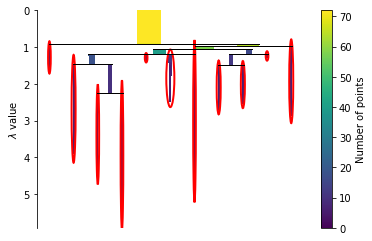

In [14]:

cluster_hdbscan.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))


In [15]:
# Alternative 
# Import library
from clusteval import clusteval

# Set parameters, as an example dbscan
ce = clusteval(cluster='hdbscan')

# Fit to find optimal number of clusters using dbscan
results= ce.fit(normalized_embeddings)




[clusteval] >Fit using hdbscan with metric: euclidean, and linkage: ward
[clusteval] >Estimated number of clusters: 12
[clusteval] >Silhouette Coefficient: 0.453
[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [13].
[clusteval] >Fin.


In [16]:
results

{'evaluate': 'hdbscan',
 'labx': array([ 0, -1,  3,  0, -1,  3,  1,  2,  2,  0, -1,  3,  0, -1,  3,  1,  2,
         2, -1, 11, 11, 11, 11, 11, 11, -1, 11, 11, 11, 11, 11, 11,  7, 10,
         7, 10, -1, -1,  7, 10,  7, 10, -1, -1,  4,  5,  4,  4,  5,  5,  4,
         5,  4,  4,  5,  5, -1,  8,  8,  9,  9, -1,  8,  8,  9,  9,  6,  6,
         6,  6,  6,  6]),
 'p': array([1.        , 0.        , 1.        , 1.        , 0.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.        , 1.        , 1.        , 0.        , 1.        ,
        1.        , 1.        , 1.        , 0.        , 0.60506449,
        0.58040417, 0.54492833, 0.7266356 , 1.        , 1.        ,
        0.        , 0.60506449, 0.58040417, 0.54492833, 0.7266356 ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.        , 0.        , 1.        , 1.        ,
        1.        , 1.        , 0.        , 0.        , 0.82079757,
        1.        , 1

((<Figure size 576x288 with 2 Axes>,
  <Figure size 576x288 with 2 Axes>,
  <Figure size 576x288 with 2 Axes>),
 (<AxesSubplot:ylabel='distance'>,
  <AxesSubplot:ylabel='$\\lambda$ value'>,
  <AxesSubplot:ylabel='$\\lambda$ value'>))

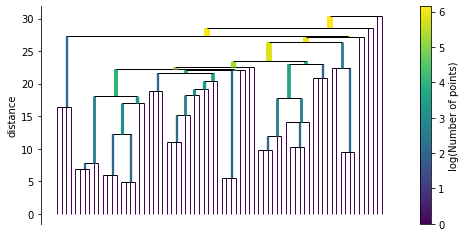

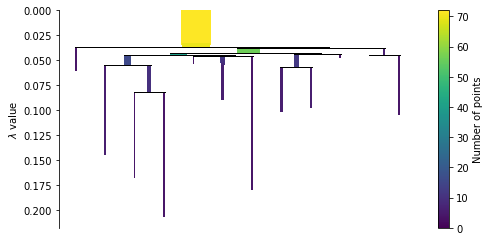

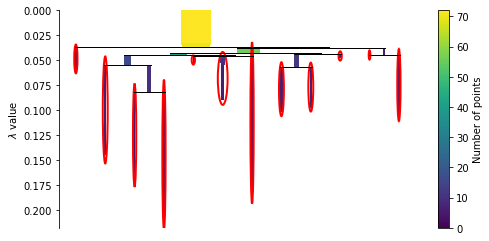

In [17]:
# Make plot of the cluster evaluation
ce.plot(figsize=(8,4))


[clusteval] >Estimated number of n_clusters: 12, average silhouette_score=0.464


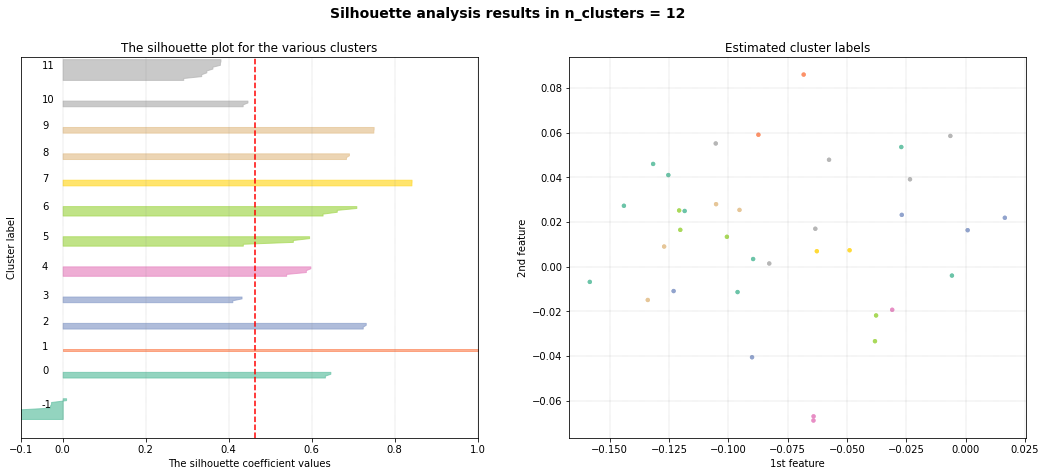

(<Figure size 1296x504 with 2 Axes>,
 <AxesSubplot:title={'center':'The silhouette plot for the various clusters'}, xlabel='The silhouette coefficient values', ylabel='Cluster label'>,
 <AxesSubplot:title={'center':'Estimated cluster labels'}, xlabel='1st feature', ylabel='2nd feature'>)

In [18]:

# Make scatter plot. Note that the first two coordinates are used for plotting.
ce.scatter(normalized_embeddings,figsize=(8,4))



In [19]:
# results is a dict with various output statistics. One of them are the labels.
cluster_labels = results['labx']

In [20]:
cluster_labels

array([ 0, -1,  3,  0, -1,  3,  1,  2,  2,  0, -1,  3,  0, -1,  3,  1,  2,
        2, -1, 11, 11, 11, 11, 11, 11, -1, 11, 11, 11, 11, 11, 11,  7, 10,
        7, 10, -1, -1,  7, 10,  7, 10, -1, -1,  4,  5,  4,  4,  5,  5,  4,
        5,  4,  4,  5,  5, -1,  8,  8,  9,  9, -1,  8,  8,  9,  9,  6,  6,
        6,  6,  6,  6])

[clusteval] >Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=1.863. Be patient now..
[clusteval] >Compute cluster labels.


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [45.0, 45.0, 55.0, 55.0],
  [30.0, 30.0, 50.0, 50.0],
  [10.0, 10.0, 40.0, 40.0],
  [65.0, 65.0, 75.0, 75.0],
  [85.0, 85.0, 95.0, 95.0],
  [105.0, 105.0, 115.0, 115.0],
  [90.0, 90.0, 110.0, 110.0],
  [70.0, 70.0, 100.0, 100.0],
  [125.0, 125.0, 135.0, 135.0],
  [145.0, 145.0, 155.0, 155.0],
  [130.0, 130.0, 150.0, 150.0],
  [85.0, 85.0, 140.0, 140.0],
  [25.0, 25.0, 112.5, 112.5],
  [165.0, 165.0, 175.0, 175.0],
  [185.0, 185.0, 195.0, 195.0],
  [205.0, 205.0, 215.0, 215.0],
  [190.0, 190.0, 210.0, 210.0],
  [225.0, 225.0, 235.0, 235.0],
  [245.0, 245.0, 255.0, 255.0],
  [230.0, 230.0, 250.0, 250.0],
  [200.0, 200.0, 240.0, 240.0],
  [170.0, 170.0, 220.0, 220.0],
  [265.0, 265.0, 275.0, 275.0],
  [285.0, 285.0, 295.0, 295.0],
  [305.0, 305.0, 315.0, 315.0],
  [290.0, 290.0, 310.0, 310.0],
  [270.0, 270.0, 300.0, 300.0],
  [325.0, 325.0, 335.0, 335.0],
  [345.0, 345.0, 355.0, 355.0],
  [330.0, 330.0, 350.0, 350.0],
  [2

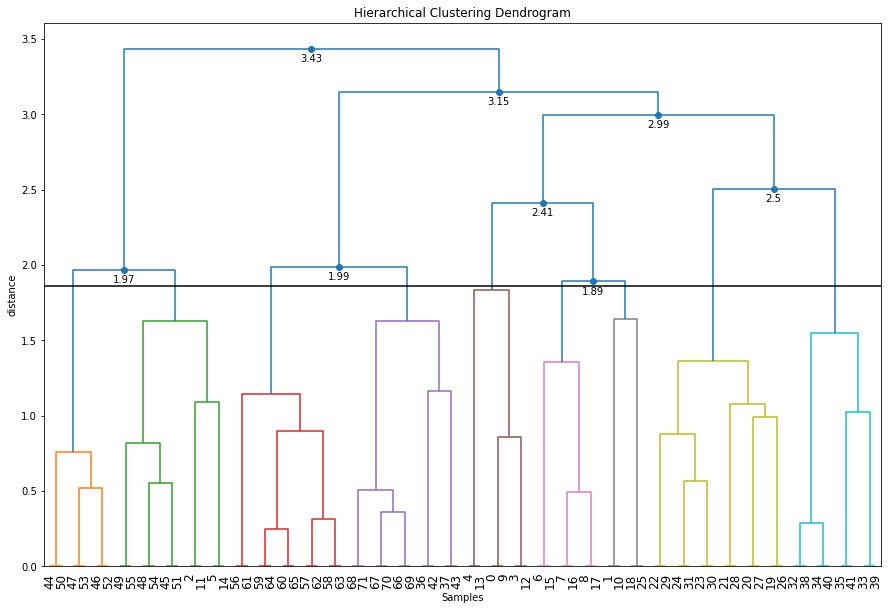

In [21]:
ce.dendrogram()

In [22]:
clustered_df.head()

,CASE_NUMBER,_TEXT_LONG,hdbscan_labels
51235,90425077,During PSSR walkdown it was found that MR05050...,0
51847,90425689,During operation of Block 2A and 2B it was fou...,-1
52066,90425908,RFI01912 Removed motor tagged 10405BMF501A BAD...,3
52324,90426166,During PSSR walkdown it was found that lines N...,0
52656,90426499,During an insulation focused walk items were f...,-1
